In [ ]:
!pip install -q torch torchvision transformers datasets pillow tqdm faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 115.5 MB/s eta 0:00:00


In [ ]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Generating & Saving Embeddings for Hugging Face Dataset

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
DATA_DIR = "/content/drive/MyDrive/CapstoneProject/Datasets/HF_8K"  # <-- CHANGE if needed

ds = load_dataset(
    "parquet",
    data_files={
        "train": [
            f"{DATA_DIR}/train-00000-of-00002-2f8f6bfa852eac4b.parquet",
            f"{DATA_DIR}/train-00001-of-00002-2173151d8cd6c7fb.parquet",
        ],
        "validation": f"{DATA_DIR}/validation-00000-of-00001-7025a2b596f14b7b.parquet",
        "test": f"{DATA_DIR}/test-00000-of-00001-42a2661d12c73e48.parquet",
    }
)

ds

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
})

In [ ]:
def explode_all_captions(split):
    df = ds[split].to_pandas()

    caption_cols = [
        "caption_0", "caption_1", "caption_2",
        "caption_3", "caption_4"
    ]

    df = df.melt(
        id_vars=["image"],
        value_vars=caption_cols,
        value_name="caption"
    )[["image", "caption"]]

    return df

In [ ]:
val_df  = explode_all_captions("validation")
test_df = explode_all_captions("test")
train_df = explode_all_captions("train")

print("Validation rows:", len(val_df))
print("Test rows:", len(test_df))

Validation rows: 5000
Test rows: 5000


In [ ]:
model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch32"
).to(device)

processor = CLIPProcessor.from_pretrained(
    "openai/clip-vit-base-patch32"
)

model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [ ]:
from io import BytesIO
from collections import defaultdict

def generate_clip_embeddings_from_df(df, split_name, output_dir, batch_size=32):
    image_embs = []
    text_embs = []
    caption_counts = []

    grouped = defaultdict(list)

    for _, row in df.iterrows():
        grouped[id(row["image"])].append((row["image"], row["caption"]))

    for image_key, items in tqdm(grouped.items()):
        raw_image, _ = items[0]
        captions = [cap for _, cap in items]

        # Convert HF image → PIL
        if isinstance(raw_image, dict) and "bytes" in raw_image:
            image = Image.open(BytesIO(raw_image["bytes"])).convert("RGB")
        else:
            image = raw_image.convert("RGB")

        inputs = processor(
            images=image,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            img_emb = model.get_image_features(**inputs)

        img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
        image_embs.append(img_emb.cpu().numpy()[0])

        text_inputs = processor(
            text=captions,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        with torch.no_grad():
            txt_emb = model.get_text_features(**text_inputs)

        txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)
        text_embs.extend(txt_emb.cpu().numpy())

        caption_counts.append(len(captions))

    os.makedirs(output_dir, exist_ok=True)

    np.save(f"{output_dir}/{split_name}_image_embs.npy", np.array(image_embs))
    np.save(f"{output_dir}/{split_name}_text_embs.npy", np.array(text_embs))
    np.save(f"{output_dir}/{split_name}_caption_counts.npy", np.array(caption_counts))

    print(f"Saved embeddings for {split_name}")

In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/CapstoneProject/Embeddings/HF_8K/val"

generate_clip_embeddings_from_df(
    df=val_df,
    split_name="val",
    output_dir=OUTPUT_DIR
)

100%|██████████| 1000/1000 [01:07<00:00, 14.90it/s]


Saved embeddings for val


In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/CapstoneProject/Embeddings/HF_8K/test"

generate_clip_embeddings_from_df(
    df=test_df,
    split_name="test",
    output_dir=OUTPUT_DIR
)

100%|██████████| 1000/1000 [00:25<00:00, 38.96it/s]

Saved embeddings for test


In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/CapstoneProject/Embeddings/HF_8K/train"

generate_clip_embeddings_from_df(
    df=train_df,
    split_name="train",
    output_dir=OUTPUT_DIR
)

100%|██████████| 6000/6000 [02:31<00:00, 39.56it/s]


Saved embeddings for train


In [ ]:
img = np.load(f"{OUTPUT_DIR}/train_hf-8k_image_embs.npy")
txt = np.load(f"{OUTPUT_DIR}/train_hf-8k_text_embs.npy")
cnt = np.load(f"{OUTPUT_DIR}/train_hf-8k_caption_counts.npy")

print(img.shape, txt.shape)
print("Total captions:", sum(cnt))

(6000, 512) (30000, 512)
Total captions: 30000


In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/CapstoneProject/Embeddings/HF_8K/test"

img = np.load(f"{OUTPUT_DIR}/test_hf-8k_image_embs.npy")
txt = np.load(f"{OUTPUT_DIR}/test_hf-8k_text_embs.npy")
cnt = np.load(f"{OUTPUT_DIR}/test_hf-8k_caption_counts.npy")

print(img.shape, txt.shape)
print("Total captions:", sum(cnt))

(1000, 512) (5000, 512)
Total captions: 5000


# Data Setup for jbrownloee flickr_8k

Source: https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [ ]:
# Convert raw captions into dataframe

data = []

with open("/content/captions.txt", "r") as f:
    lines = f.readlines()

skipped = 0
for line in lines:
    parts = line.strip().split(" ",1)
    if len(parts) != 2:
        skipped += 1
        print(f"Skipping malformed line: {line}")
        continue  # or log: print(f"Skipping malformed line: {line}")
    image_id, caption = parts
    image = image_id.split("#")[0]
    data.append((image, caption.strip()))

print(f"Skipped {skipped} malformed lines.")

import pandas as pd
df = pd.DataFrame(data, columns=["image", "caption"])
df.head()


Skipping malformed line: image,caption

Skipping malformed line: 2199200615.jpg,

Skipped 2 malformed lines.


,image,caption
0,"1000092795.jpg,",Two young guys with shaggy hair look at their ...
1,"1000092795.jpg,""","Two young , White males are outside near many ..."
2,"1000092795.jpg,",Two men in green shirts are standing in a yard .
3,"1000092795.jpg,",A man in a blue shirt standing in a garden .
4,"1000092795.jpg,",Two friends enjoy time spent together .


In [ ]:
# Generate CSV files using the dataframes

import pandas as pd

# 1. Load captions
captions = pd.read_csv("/content/Flickr8k.token.txt", sep="\t", names=["image_id", "caption"])
captions["image"] = captions["image_id"].apply(lambda x: x.split("#")[0])

# 2. Load split image lists
def load_image_list(filepath):
    with open(filepath, "r") as f:
        return [line.strip() for line in f.readlines()]

train_imgs = load_image_list("/content/Flickr_8k.trainImages.txt")
val_imgs = load_image_list("/content/Flickr_8k.devImages.txt")
test_imgs = load_image_list("/content/Flickr_8k.testImages.txt")

# 3. Filter captions by split
train_df = captions[captions["image"].isin(train_imgs)]
val_df = captions[captions["image"].isin(val_imgs)]
test_df = captions[captions["image"].isin(test_imgs)]

# 4. Save CSVs
train_df.to_csv("flickr8k_train.csv", index=False)
val_df.to_csv("flickr8k_val.csv", index=False)
test_df.to_csv("flickr8k_test.csv", index=False)

In [ ]:
df.to_csv("flickr30k_all_captions.csv",index=False)

In [ ]:
# split into Train/Validation/Test (80/10/10)

from sklearn.model_selection import train_test_split

unique_images = df["image"].unique()
train_imgs, temp_imgs = train_test_split(unique_images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

def save_split(ids, name):
    split_df = df[df["image"].isin(ids)]
    split_df.to_csv(f"flickr30k_{name}.csv", index=False)

save_split(train_imgs, "train")
save_split(val_imgs, "val")
save_split(test_imgs, "test")

**Googl Drive Paths**

In [ ]:
# flick8k dataset paths
flickr8k_dir = "/content/drive/MyDrive/CapstoneProject/Datasets/Flickr8k_images"
flickr8k_csv_dir = "/content/drive/MyDrive/CapstoneProject/Datasets/Flickr8k_text"
flickr30k_dir = "/content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_images"
flickr30k_csv_dir = "/content/drive/MyDrive/CapstoneProject/Datasets/Flickr30k_captions"
output_dir = "/content/drive/MyDrive/CapstoneProject/Embeddings"

# Huggingface - flick8k dataset path
flickr8k_hf_dir = "/content/drive/MyDrive/CapstoneProject/Datasets/HF_8K"
flickr30k_hf_dir = "/content/drive/MyDrive/CapstoneProject/Datasets/HF_30K"
hf_output_dir = "/content/drive/MyDrive/CapstoneProject/Embeddings/HF_30K"

# Load CLIP Model and Processor

In [ ]:
!pip install transformers ftfy
import torch
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Generating & Savings Embeddings for jbrownlee dataset

In [ ]:
from PIL import Image
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from io import BytesIO

In [ ]:
# Functions for getting embeddings

def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    return outputs.cpu().numpy().squeeze()


def get_image_embedding_hf(image):
    image = image.convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    return outputs.cpu().numpy().squeeze()


def get_text_embeddings(captions):
    inputs = processor(text=captions, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = model.get_text_features(**inputs)
    return outputs.cpu().numpy()

In [ ]:
# Function to generate embeddings from flick8 dataset splits

def generate_clip_embeddings(csv_file, img_dir, split_name, output_dir):
    df = pd.read_csv(csv_file, names=["image", "caption"], quoting=3, on_bad_lines='skip', engine='python')
    #df = pd.read_csv(csv_file)
    grouped = df.groupby("image")

    image_embs = []
    text_embs = []
    image_found = 0

    for img_name, group in tqdm(grouped):
        img_path = os.path.join(img_dir, img_name)
        if not os.path.exists(img_path):
            print(f"Missing: {img_path}")
            continue
        image_found += 1
        try:
            image_emb = get_image_embedding(img_path)
            text_emb = get_text_embeddings(group["caption"].tolist())

            image_embs.append(image_emb)
            text_embs.extend(text_emb)
        except Exception as e:
            print(f"Error with {img_name}: {e}")
            continue

    print(f"Processed {image_found} images.")

    np.save(os.path.join(output_dir, f"{split_name}_image_embs.npy"), image_embs)
    np.save(os.path.join(output_dir, f"{split_name}_text_embs.npy"), text_embs)

In [ ]:
# Genrate embeddings for train/test/val

generate_clip_embeddings(
    csv_file= flickr8k_csv_dir + "/flickr8k_train.csv",
    img_dir= flickr8k_dir,
    split_name="flickr8k_train",
    output_dir=output_dir
)

generate_clip_embeddings(
    csv_file= flickr8k_csv_dir + "/flickr8k_val.csv",
    img_dir= flickr8k_dir,
    split_name="flickr8k_val",
    output_dir=output_dir
)

generate_clip_embeddings(
    csv_file= flickr8k_csv_dir + "/flickr8k_test.csv",
    img_dir= flickr8k_dir,
    split_name="flickr8k_test",
    output_dir=output_dir
)

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: Image loading from CSV not implemented. Provide img_dir.

In [ ]:
# Function to Generate image and text embeddings directly from a DataFrame containing PIL Images and caption strings.
# generate_clip_embeddings_from_df.py
import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from PIL import Image
from io import BytesIO

def generate_clip_embeddings_from_df(df, split_name, output_dir):
    image_embs = []
    text_embs = []
    grouped = defaultdict(list)

    for _, row in df.iterrows():
        image_key = row['image']['path'] if isinstance(row['image'], dict) and 'path' in row['image'] else str(_)
        grouped[image_key].append((row['image'], row['caption']))

    image_found = 0
    for image_key, items in tqdm(grouped.items()):
        try:
            raw_image, _ = items[0]  # same image across group
            captions = [cap for _, cap in items]

            # Convert Hugging Face image dict to PIL Image
            if isinstance(raw_image, dict) and 'bytes' in raw_image:
                image = Image.open(BytesIO(raw_image['bytes'])).convert("RGB")
            else:
                image = raw_image.convert("RGB")

            image_emb = get_image_embedding_hf(image)
            caption_embs = get_text_embeddings(captions)

            image_embs.append(image_emb)
            text_embs.extend(caption_embs)
            image_found += 1
        except Exception as e:
            print(f"Error processing image group {image_key}: {e}")
            continue

    print(f"Processed {image_found} images.")

    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, f"{split_name}_image_embs.npy"), image_embs)
    np.save(os.path.join(output_dir, f"{split_name}_text_embs.npy"), text_embs)
    print(f"Saved embeddings to {output_dir}")


In [ ]:
# Function to generate embeddings from HuggingFace dataset

from datasets import load_dataset
#from generate_clip_embeddings_from_df import generate_clip_embeddings_from_df

# # Load the Hugging Face dataset
# ds = load_dataset("jxie/flickr8k")
# train_df = ds["train"].to_pandas()

# # Use a single caption per image (e.g., the first one)
# train_df["caption"] = train_df["caption_0"]
# train_df = train_df[["image", "caption"]]

# # Generate embeddings
# generate_clip_embeddings_from_df(
#     df=train_df,
#     split_name="flickr8k_hf_train",
#     output_dir= output_dir
# )

# Load dataset from Hugging Face
ds = load_dataset("jxie/flickr8k")

# Process validation split
val_df = ds["validation"].to_pandas()
val_df["caption"] = val_df["caption_0"]  # Or pick any other caption column
val_df = val_df[["image", "caption"]]

generate_clip_embeddings_from_df(
    df=val_df,
    split_name="flickr8k_hf_val",
    output_dir=output_dir
)

# Process test split
test_df = ds["test"].to_pandas()
test_df["caption"] = test_df["caption_0"]
test_df = test_df[["image", "caption"]]

generate_clip_embeddings_from_df(
    df=test_df,
    split_name="flickr8k_hf_test",
    output_dir=output_dir
)

100%|██████████| 1000/1000 [00:26<00:00, 37.93it/s]


Processed 1000 images.
Saved embeddings to /content/drive/MyDrive/CapstoneProject/Embeddings


100%|██████████| 1000/1000 [00:26<00:00, 38.21it/s]


Processed 1000 images.
Saved embeddings to /content/drive/MyDrive/CapstoneProject/Embeddings


# Recall@K results for retrieval tasks

In [ ]:
# Load & Normalize Embeddings

# Load
image_embs = np.load("/content/drive/MyDrive/CapstoneProject/Embeddings/flickr8k_train_image_embs.npy")
text_embs = np.load("/content/drive/MyDrive/CapstoneProject/Embeddings/flickr8k_train_text_embs.npy")
df = pd.read_csv(flickr8k_csv_dir+"/flickr8k_train.csv")

# Normalize
def normalize(vectors):
    return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

image_embs = normalize(image_embs)
text_embs = normalize(text_embs)

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.6 MB/s eta 0:00:00


In [ ]:
# Create FAISS index for image embeddings
import faiss

index = faiss.IndexFlatIP(image_embs.shape[1])
index.add(image_embs)

top_k = 5
scores, indices = index.search(text_embs, top_k)

# Assume captions are ordered: 5 captions per image, in order
# So caption 0–4 → image 0, 5–9 → image 1, etc.
correct_image_indices = np.repeat(np.arange(len(image_embs)), 5)

# Check if correct index is in top K results
recall_at_k = (correct_image_indices[:, None] == indices).any(axis=1).mean()
print(f"Recall@{top_k}: {recall_at_k:.4f}")

In [ ]:
for k in [1, 5, 10]:
    r_at_k = (correct_image_indices[:, None] == indices[:, :k]).any(axis=1).mean()
    print(f"Recall@{k}: {r_at_k:.4f}")

Recall@1: 0.5482
Recall@5: 0.8174
Recall@10: 0.8174


In [ ]:
import numpy as np
import faiss

# Load embeddings (e.g., validation)
image_embs = np.load("/content/drive/MyDrive/CapstoneProject/Embeddings/flickr8k_hf_val_image_embs.npy")
text_embs = np.load("/content/drive/MyDrive/CapstoneProject/Embeddings/flickr8k_hf_val_text_embs.npy")

# Normalize
def normalize(vectors):
    return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

image_embs = normalize(image_embs)
text_embs = normalize(text_embs)

# Build FAISS index
index = faiss.IndexFlatIP(image_embs.shape[1])
index.add(image_embs)

# Search text → image
K = 10
scores, indices = index.search(text_embs, K)

# Assumes: every 5 text embeddings belong to 1 image
# num_captions_per_image = 5
# correct_image_indices = np.repeat(np.arange(len(image_embs)), num_captions_per_image)
correct_image_indices = np.arange(len(text_embs))


print("image_embs.shape:", image_embs.shape)
print("text_embs.shape:", text_embs.shape)

# Compute Recall@K
for k in [1, 5, 10]:
    recall_at_k = (correct_image_indices[:, None] == indices[:, :k]).any(axis=1).mean()
    print(f"Text → Image Recall@{k}: {recall_at_k:.4f}")

image_embs.shape: (1000, 512)
text_embs.shape: (1000, 512)
Text → Image Recall@1: 0.5590
Text → Image Recall@5: 0.8080
Text → Image Recall@10: 0.8860


# Verification of Image retrieval for top 5

Query: A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .


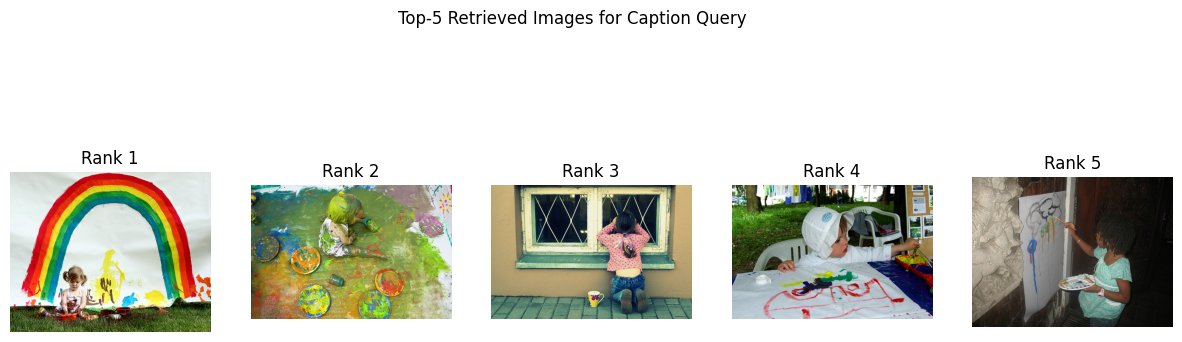

In [ ]:
sample_idx = 10 # sample caption index
query_caption = df.iloc[sample_idx]["caption"]
query_image = df.iloc[sample_idx]["image"]
print(f"Query: {query_caption}")

# Get matching text embedding
query_text_vector = text_embs[sample_idx:sample_idx+1]  # shape (1, 512)

# Search top 5 similar images
scores, indices = index.search(query_text_vector, 5)
top_images = df["image"].unique()[indices[0]]

image_dir = flickr8k_dir

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(top_images):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Rank {i+1}")

plt.suptitle("Top-5 Retrieved Images for Caption Query")
plt.show()

Query: A child gets squirted while squirting a water gun .


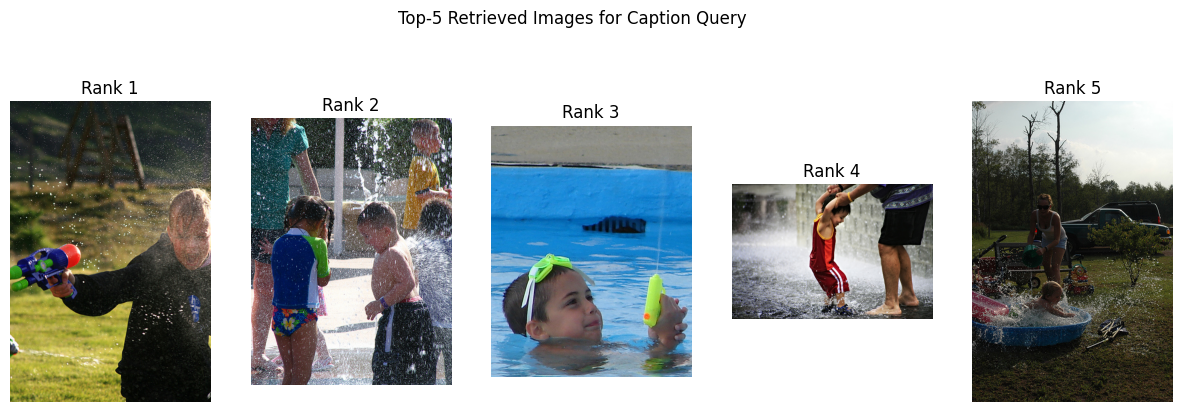

In [ ]:
# Verification of Image retrieval for top 5 for hugging face dataset

import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from datasets import load_dataset

# Load Hugging Face dataset and extract validation split (or test/train)
ds = load_dataset("jxie/flickr8k")
df = ds["validation"].to_pandas()  # or "test", "train"

# If you only used one caption per image
df["caption"] = df["caption_0"]

sample_idx = 10  # Index of query caption
query_caption = df.iloc[sample_idx]["caption"]
query_image = df.iloc[sample_idx]["image"]
print(f"Query: {query_caption}")

# Get matching text embedding
query_text_vector = text_embs[sample_idx:sample_idx+1]

# Search top 5 similar images
scores, indices = index.search(query_text_vector, 5)
top_images = df.iloc[indices[0]]["image"].tolist()

# Plot top 5 images
plt.figure(figsize=(15, 5))
for i, img_dict in enumerate(top_images):
    img = Image.open(BytesIO(img_dict["bytes"])).convert("RGB")
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Rank {i + 1}")

plt.suptitle("Top-5 Retrieved Images for Caption Query")
plt.show()
